In [1]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
file_path = r"M-30-HD"
image_files = [f for f in os.listdir(file_path) if f.endswith('.jpg')]
image_dir = sorted(
    [os.path.join(file_path, fname) for fname in image_files],
    key=lambda x: float(re.findall(r"(\d+)", os.path.basename(x))[0])
)

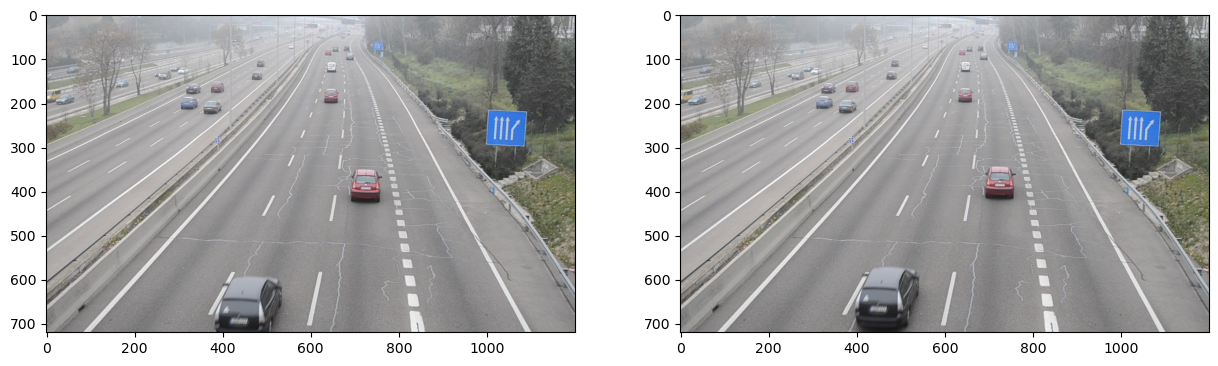

In [34]:
index_val = 317

image1 = cv2.imread(image_dir[index_val])
image2 = cv2.imread(image_dir[index_val+1])


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

plt.show()

In [35]:
image1.shape

(720, 1200, 3)

In [36]:
def calculate_flow(frame1, frame2):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow

In [37]:
def flow_visualize(flow):
    
    height, width = flow.shape[:2]
    hsv = np.zeros((height, width, 3), dtype=np.uint8)
    hsv[..., 1] = 255
    mag = np.linalg.norm(flow, axis=2)
    ang = np.arctan2(flow[..., 1], flow[..., 0])
    hsv[..., 0] = (ang + np.pi) * (180 / np.pi / 2)
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return rgb

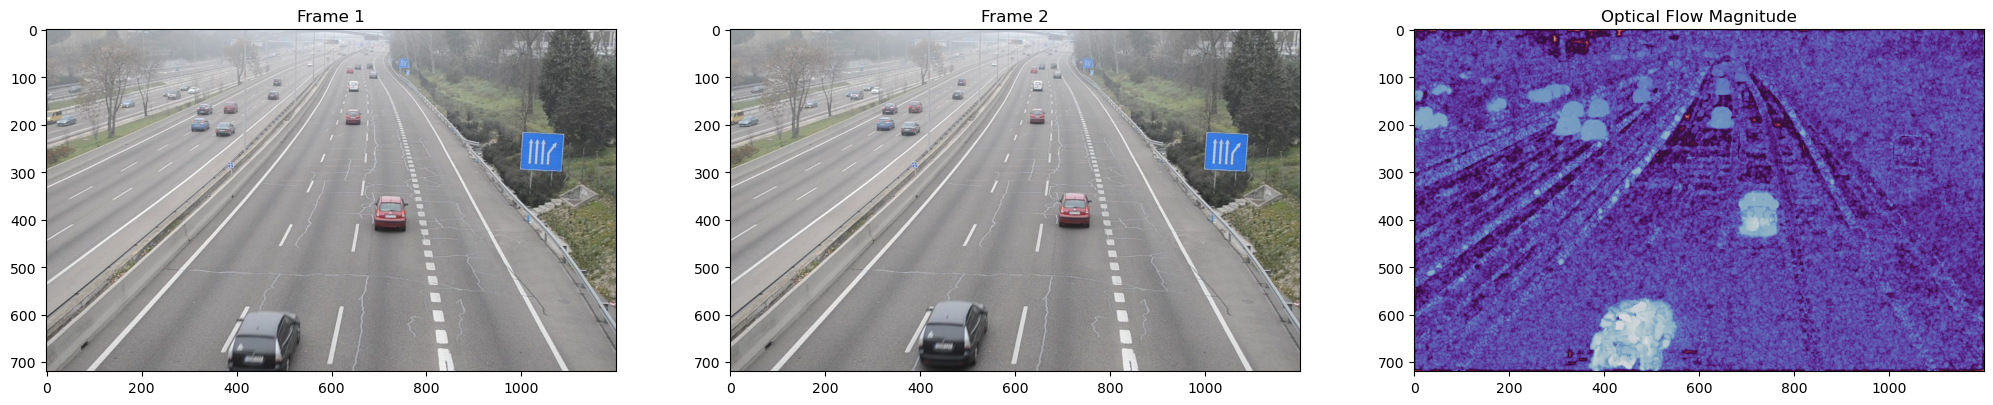

In [38]:
flow = calculate_flow(image1, image2)
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
img1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(np.log(mag/mag.max()), cmap='twilight_r') 
ax[2].set_title('Optical Flow Magnitude');

In [39]:
def mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    
    mask = np.uint8(flow_mag > motion_thresh)*255

    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return mask

Text(0.5, 1.0, 'Dense Optical Flow')

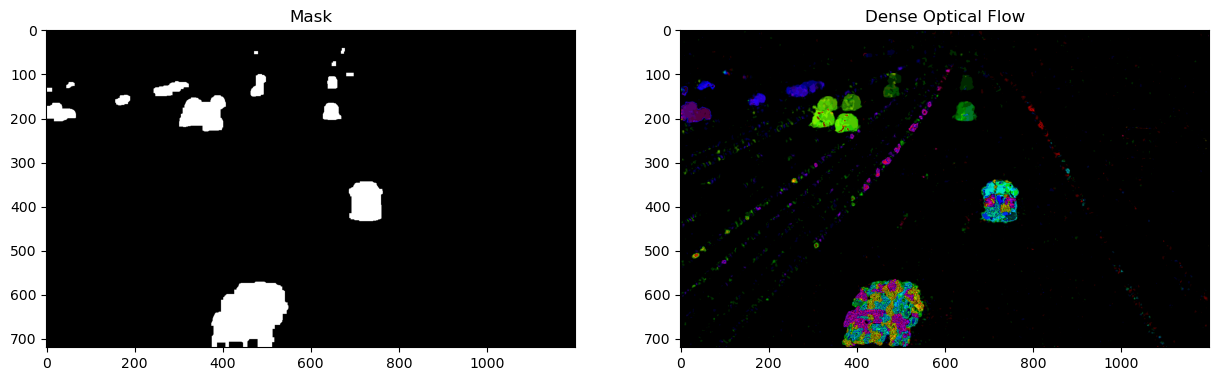

In [40]:
rgb = flow_visualize(flow)

motion_thresh = np.c_[np.linspace(0.1, 1, 720)].repeat(1200, axis=-1)
mask = mask(mag, motion_thresh=motion_thresh)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Mask")
ax[1].imshow(rgb*40)
ax[1].set_title("Dense Optical Flow")

In [41]:
def get_contour_dtct_points(mask, ang, angle_thresh=2, thresh=400):

    contours, _ = cv2.findContours(
        mask, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE  
    )
    temp_mask = np.zeros_like(mask)  
    adjusted_angle_thresh = angle_thresh * ang.std()
    dtct_points = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[temp_mask > 0]
        if (area > thresh) and (flow_angle.std() < adjusted_angle_thresh):
            dtct_points.append([x, y, x + w, y + h, area])
        temp_mask.fill(0)
    
    return np.array(dtct_points)

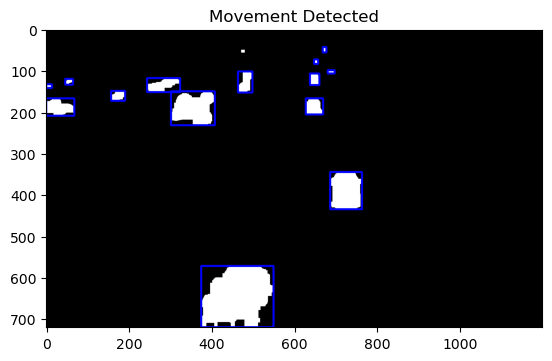

In [42]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
dtct_points = get_contour_dtct_points(mask, ang, angle_thresh=4, thresh=100)
bboxes = dtct_points[:, :4]
scores = dtct_points[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (0,0,255), 3)

plt.imshow(mask_rgb)
plt.title("Movement Detected");

In [43]:
def remove_contained_bboxes(boxes):

    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep:
        for j in range(0, len(boxes)):
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep

def non_max_suppression(boxes, scores, threshold=1e-1):

    boxes = boxes[np.argsort(scores)[::-1]]
    order = remove_contained_bboxes(boxes)
    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

In [44]:
mst_conf_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(mst_conf_bboxes)

(14, 14)

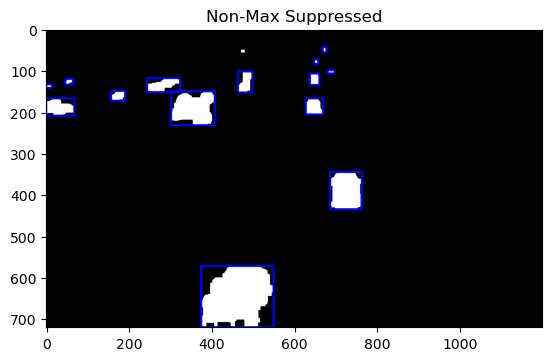

In [45]:
mask_rgb_dtct_points = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in mst_conf_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_dtct_points, (x1,y1), (x2,y2), (0,0,255), 3)

plt.imshow(mask_rgb_dtct_points)
plt.title("Non-Max Suppressed");


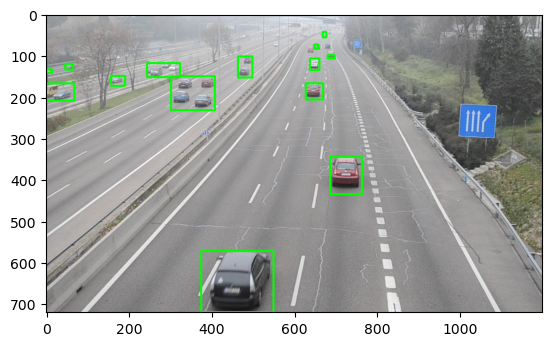

In [46]:
frame2 = img2_rgb.copy()

for det in mst_conf_bboxes:
    x1,y1,x2,y2 = det
    cv2.rectangle(frame2, (x1,y1), (x2,y2), (0,255,0), 3)

plt.imshow(frame2);